In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import quantstats as qs

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from Trader import TradingEngine

# Compute beta

Use historical price data from the period 2000-01-01 -> 2020-12-31 to calculate the hedge ratio to use in strategy

In [4]:
# WTI crude oil futures data
temp1 = yf.download('BZ=F', start='2004-01-01', end='2023-12-31', interval='1d')
temp1.columns = [f"{price}" for price, _ in temp1.columns]
# Heating oil futures data
temp2 = yf.download('HO=F', start='2004-01-01', end='2023-12-31', interval='1d')
temp2.columns = [f"{price}" for price, _ in temp2.columns]

temp_df = pd.DataFrame({
    'crude_price': temp1['Close'],
    'ho_price': temp2['Close']
}).dropna()

C:\Users\Owen\AppData\Local\Temp\ipykernel_8956\802961320.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp1 = yf.download('BZ=F', start='2004-01-01', end='2023-12-31', interval='1d')
[*********************100%***********************]  1 of 1 completed
C:\Users\Owen\AppData\Local\Temp\ipykernel_8956\802961320.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp2 = yf.download('HO=F', start='2004-01-01', end='2023-12-31', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [5]:
X_var = sm.add_constant(temp_df['ho_price'])    # Independent variable
y_var = temp_df['crude_price']                  # Dependent variable

model = sm.OLS(y_var, X_var).fit()
beta = model.params['ho_price']
print("Hedge Ratio (Beta):", beta)


Hedge Ratio (Beta): 32.09031265413012


<Axes: xlabel='Date'>

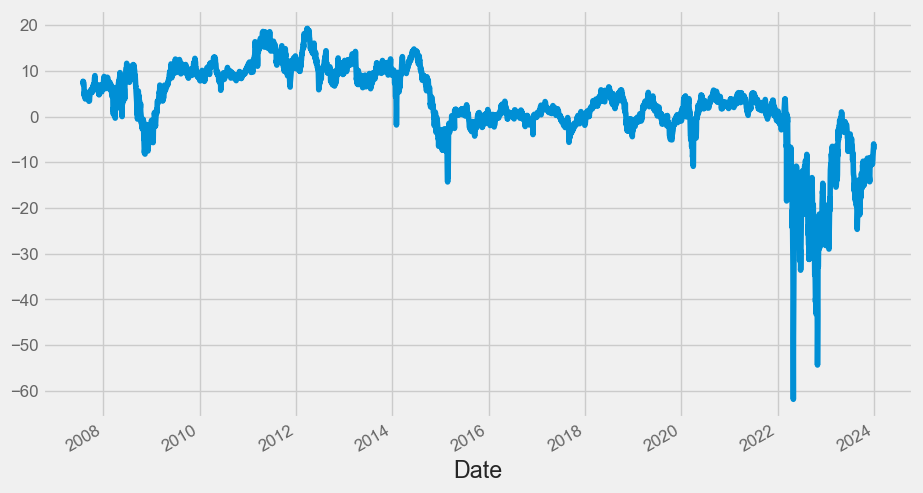

In [6]:
temp_df['spread'] = temp_df.crude_price - 33 * temp_df.ho_price

temp_df.spread.plot()

# Data

In [8]:
start = '2024-01-01'
end = '2025-08-01'

In [9]:
# Brent crude oil futures data
crude_df = yf.download('BZ=F', start=start, end=end, interval='1h')
crude_df.columns = [f"{price}" for price, _ in crude_df.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_8956\652494737.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  crude_df = yf.download('BZ=F', start=start, end=end, interval='1h')
[*********************100%***********************]  1 of 1 completed


In [10]:
# Heating oil futures data
ho_df = yf.download('HO=F', start=start, end=end, interval='1h')
ho_df.columns = [f"{price}" for price, _ in ho_df.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_8956\3926705908.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ho_df = yf.download('HO=F', start=start, end=end, interval='1h')
[*********************100%***********************]  1 of 1 completed


In [11]:
df = pd.DataFrame({
    'crude_price': crude_df['Close'],
    'ho_price': ho_df['Close']
}).dropna()

In [12]:
# Construct spread
df['spread'] = (df['crude_price'] - beta * df['ho_price'])

# Construct upper and lower bounds based off the spreads trend and volatility
n_stds = 2
rolling_window = 1000
df['spread_ma'] = df.spread.rolling(window=rolling_window).mean()
df['spread_ub'] = df.spread_ma + df.spread.rolling(window=rolling_window).std() * n_stds
df['spread_lb'] = df.spread_ma - df.spread.rolling(window=rolling_window).std() * n_stds

# Construct buy and sell signals
df['buy_signal'] = (df.spread < df.spread_lb).astype(int)
df['sell_signal'] = -(df.spread > df.spread_ub).astype(int)

# Some plots

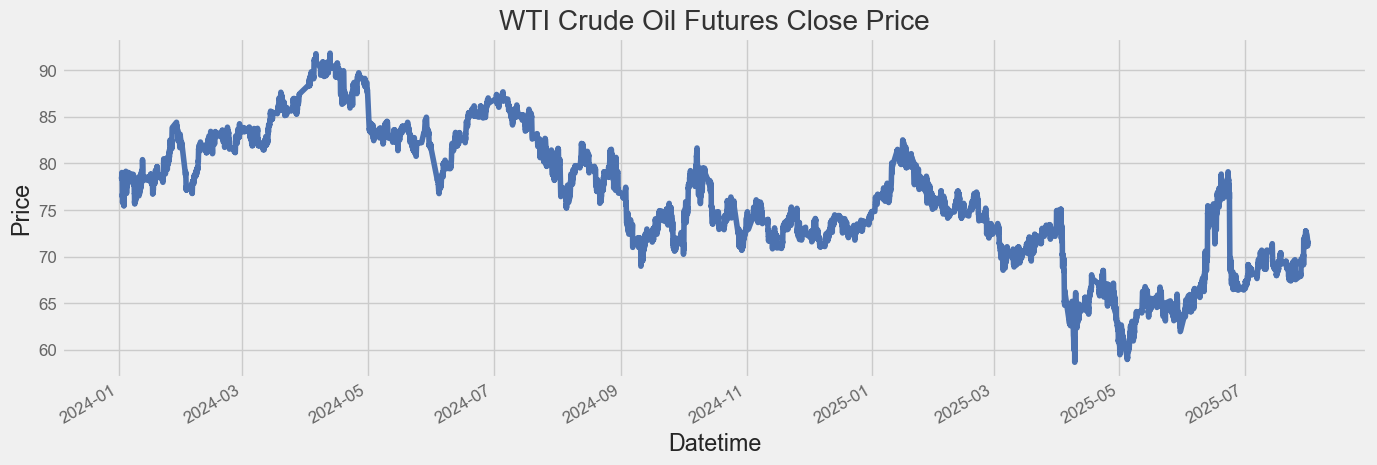

In [14]:
df.crude_price.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='WTI Crude Oil Futures Close Price', 
              ylabel='Price')
plt.show()

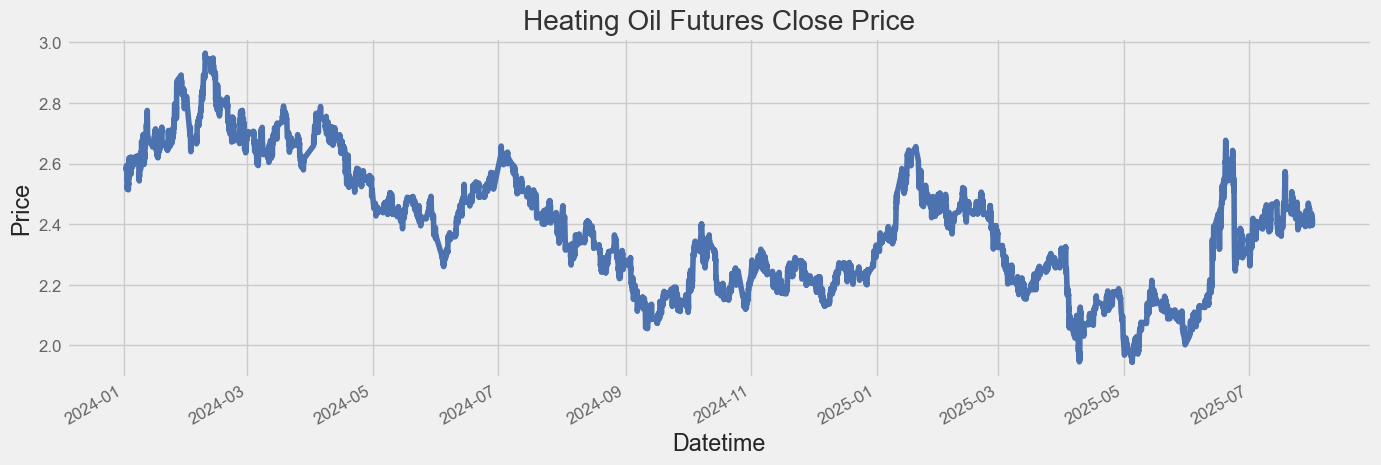

In [15]:
df.ho_price.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Heating Oil Futures Close Price', 
              ylabel='Price')
plt.show()

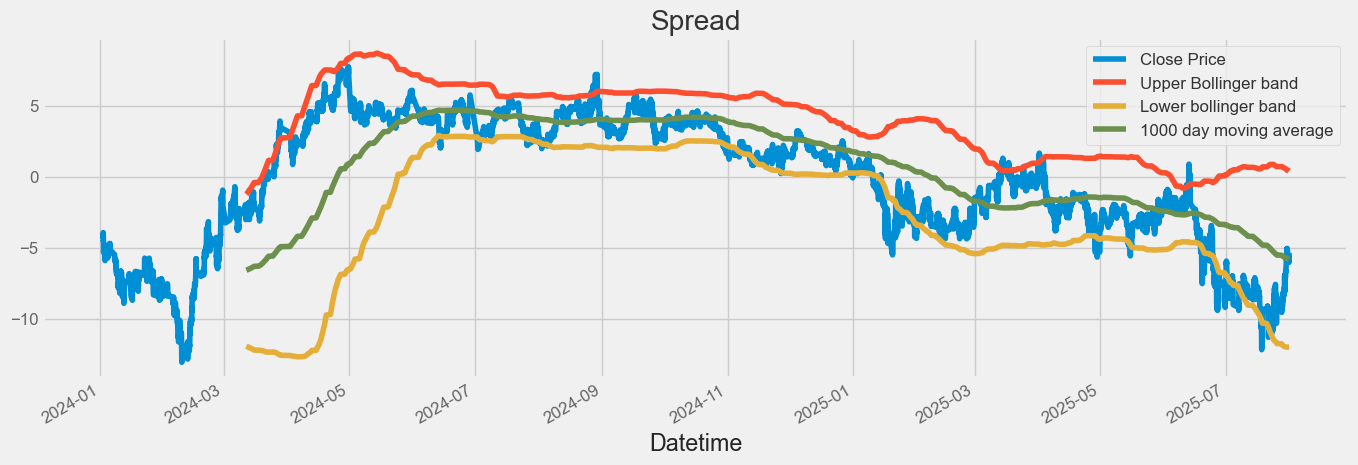

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
df.spread.plot(ax=ax, label='Close Price', title='Spread')
df.spread_ub.plot(ax=ax, label='Upper Bollinger band')
df.spread_lb.plot(ax=ax, label='Lower bollinger band')
df.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

# Implement strategy / backtesting

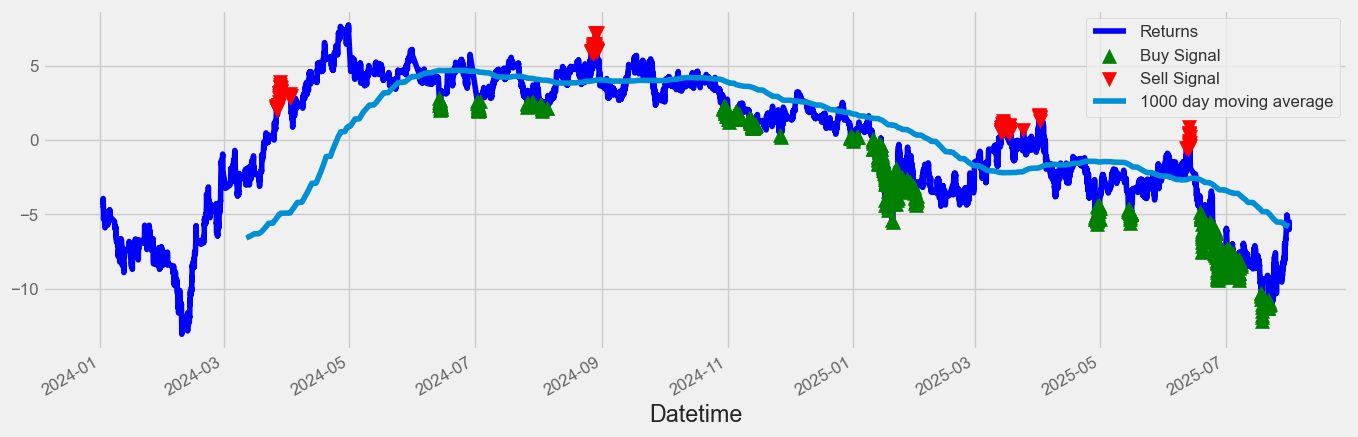

In [18]:
buy_mask = df.buy_signal > 0
sell_mask = df.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.index, df['spread'], label='Returns', color='blue')
ax.scatter(df.index[buy_mask], df['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df.index[sell_mask], df['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [19]:
trader = TradingEngine(balance=1000)

In [20]:
returns = trader.run_strategy(np.array(df.buy_signal), np.array(df.sell_signal), np.array(df.spread), 
                    np.array(df.spread_ma), df.index, allow_negative_balance=False)

# Performance evaluation

In [22]:
print(f'Final balance: {trader.balance:.2f}')
print(f'Net position: {trader.position}')
print(f'Number of trades: {trader.trade_count}')

Final balance: 2368.49
Net position: 0
Number of trades: 854


                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2025-07-31
Risk-Free Rate             0.0%
Time in Market             49.0%

Cumulative Return          136.85%
CAGR﹪                     45.82%

Sharpe                     0.24
Prob. Sharpe Ratio         91.89%
Smart Sharpe               0.16
Sortino                    0.36
Smart Sortino              0.25
Sortino/√2                 0.26
Smart Sortino/√2           0.18
Omega                      1.1

Max Drawdown               -52.52%
Max DD Date                2025-07-18
Max DD Period Start        2025-06-24
Max DD Period End          2025-07-29
Longest DD Days            94
Volatility (ann.)          32.01%
Calmar                     0.87
Skew                       1.79
Kurtosis                   43.47

Expected Daily %           0.01%
Expected Monthly %         4.64%
Expected Yearly %          53.9%
Kelly Criterion            4.61%
Risk of Ruin  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2025-06-24,2025-07-18,2025-07-29,36,-52.518544,-43.533239
2,2025-01-23,2025-02-12,2025-04-04,72,-41.625934,-38.953409
3,2025-01-14,2025-01-20,2025-01-22,9,-34.156625,-27.249088
4,2024-11-22,2024-11-26,2024-12-03,11,-26.999245,-25.361038
5,2024-04-03,2024-04-30,2024-07-05,94,-18.216507,-16.979465


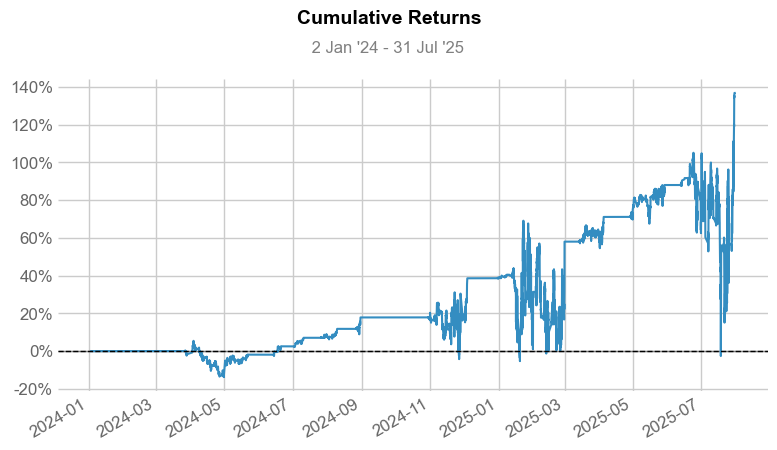

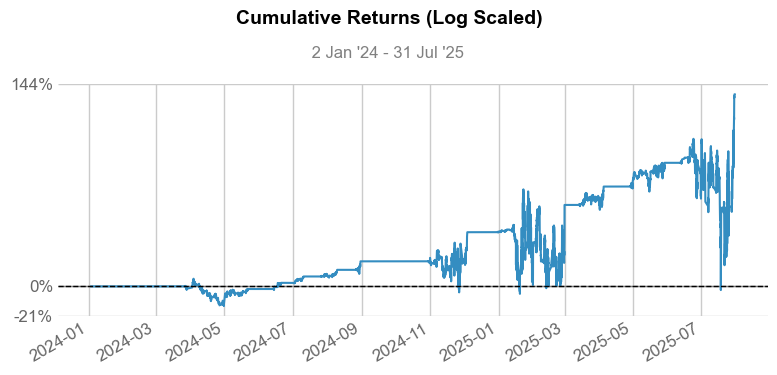

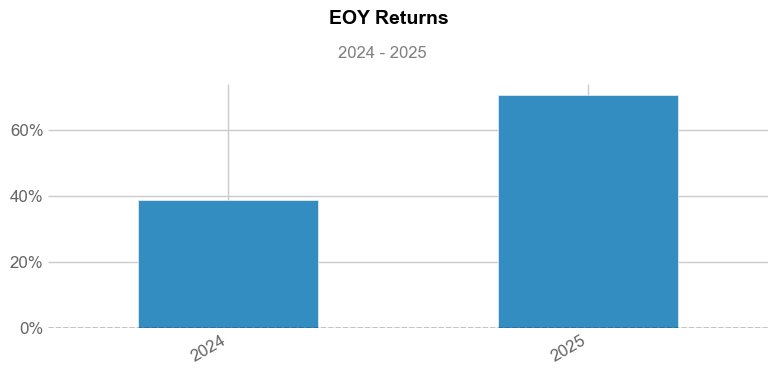

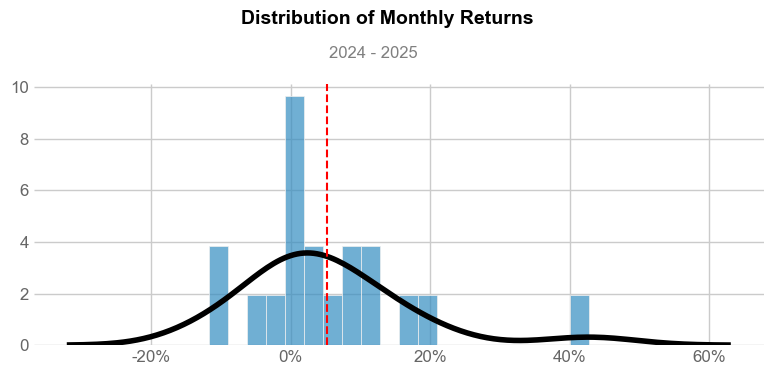

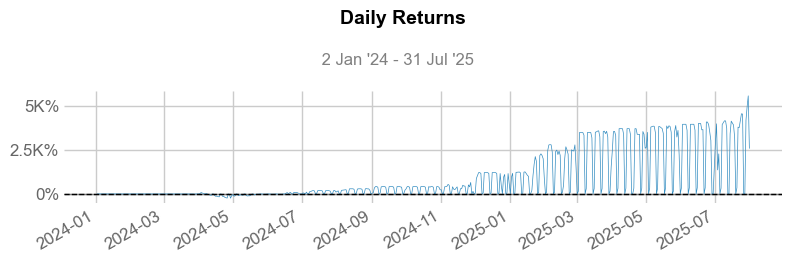

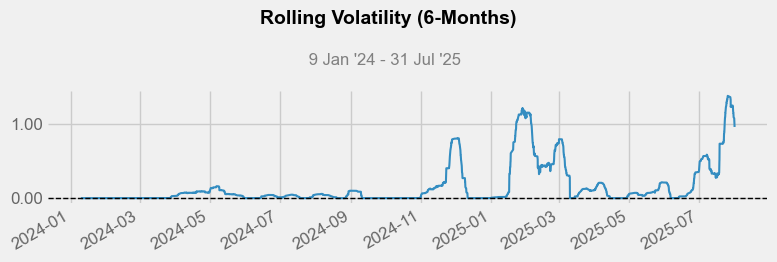

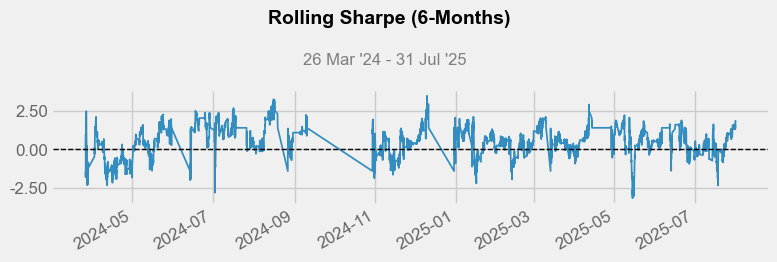

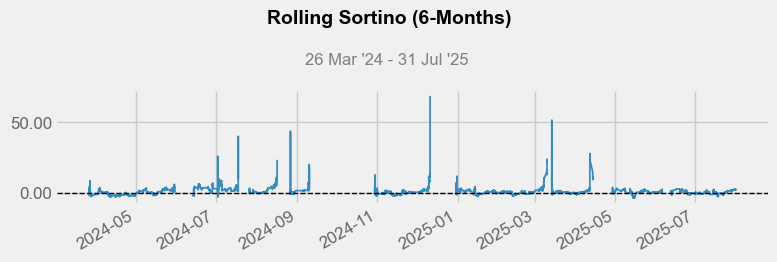

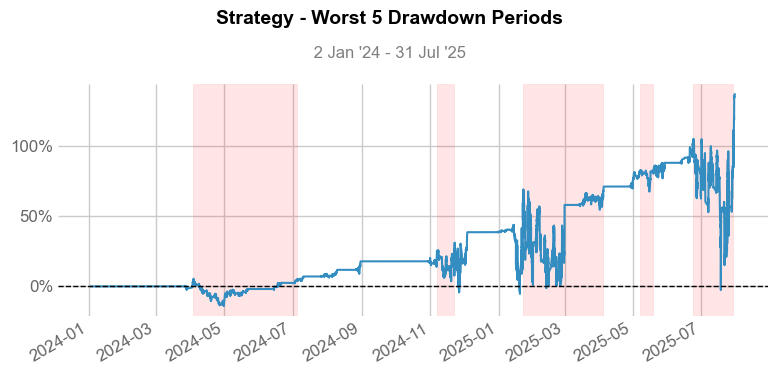

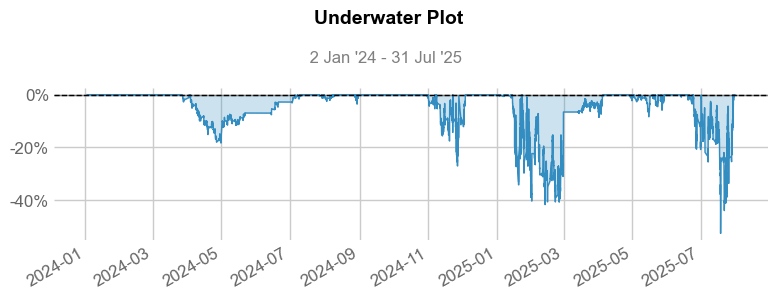

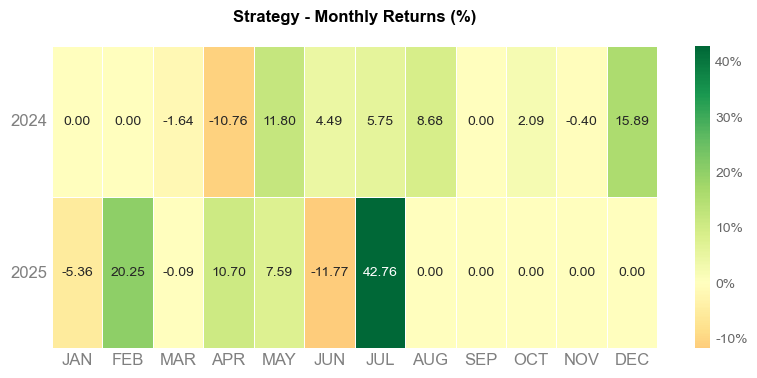

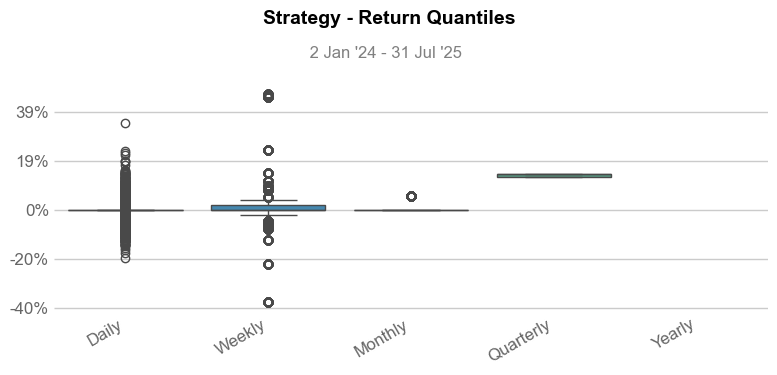

In [23]:
#qs.reports.html(returns)
qs.reports.full(returns)